In [1]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM

In [2]:
# simulation setting
test_size = 14780-2**13 #2**13
n_steps = 2**10
stepsize = 0.001
n_feature = 10
n_qubits_list = np.arange(6, 13+1, dtype=int) # 6 7 8 9 10 11 12 13
n_layers_list = np.arange(1, 19+1, 2, dtype=int) # 1 3 5 7 9 11 13 15 17 19
C=10**3
lamda=10**3
dir_name = 'numerical_simulation_cpu1'

In [3]:
def load_train_and_test_data(dataset, train_size:float=2**13, test_size:float=2**7, reproducible_seed:int=None):
    data = dataset.data.to_numpy()
    label = dataset.target.to_numpy().astype(float)
    # label = np.where(label%2, 1, 0)
    mask = (label==0) + (label==1)
    data = data[mask]
    label = label[mask]
    if reproducible_seed is None:
        reproducible_seed = np.random.randint(99999)
    X_train, X_test, y_train, y_test = train_test_split(data, label, train_size=train_size, test_size=test_size, random_state=reproducible_seed)
    return X_train, y_train, X_test, y_test, reproducible_seed

def reduce_and_normalize_data(n_components, X_train, X_test):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)
    X_train = scaler.fit_transform(X_train)
    X_train = pca.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test = pca.transform(X_test)
    for i, d in enumerate(X_train):
        X_train[i] = d/np.linalg.norm(d)
    for i, d in enumerate(X_test):
        X_test[i] = d/np.linalg.norm(d)
    return X_train, X_test

def construct_training_and_test_quantum_kernel_matrix(feature_map:QuantumCircuit, X_train:np.ndarray, X_test:np.ndarray):
    quantum_instance = QuantumInstance(backend = StatevectorSimulator(device='CPU')) # TODO: gpu vs cpu
    quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=False)
    training_kernel = quantum_kernel.evaluate(X_train, X_train)
    test_kernel = quantum_kernel.evaluate(X_train, X_test)
    return training_kernel, test_kernel

def train_and_test_reference(cvxsvm:CvxSoftQASVM, train_kernel:np.ndarray, test_kernel:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    cvxsvm.fit(train_kernel, y_train)
    fvec = cvxsvm.f(test_kernel.T)
    accuarcy = cvxsvm.accuracy(test_kernel.T, y_test)
    cost = cvxsvm.dual_objective_value
    return fvec, accuarcy, cost

def epsilon(fvec, true_fvec):
    return np.sqrt(np.mean(np.abs(fvec-true_fvec)**2)).item()

def make_figure(df:DataFrame):
    fig, ax = plt.subplots()
    mappable = ax.imshow(df, cmap='binary')
    ax.set_xlabel('n_qubits')
    ax.set_ylabel('n_layers')
    ax.set_xticks(np.arange(len(n_qubits_list)))
    ax.set_yticks(np.arange(len(n_layers_list)))
    ax.set_xticklabels(n_qubits_list)
    ax.set_yticklabels(n_layers_list)
    fig.colorbar(mappable)
    return fig

In [4]:
# setting
dir_path = Path.cwd() / dir_name
dir_path.mkdir(parents=True, exist_ok=True)
dataset = fetch_openml('mnist_784')
print('loaded mnist data set')

loaded mnist data set


In [5]:
from pandas import read_csv

if dir_path.joinpath('epsilon_summary').exists():
    epsilon_summary = read_csv(dir_path.joinpath('epsilon_summary'), index_col=0)
    epsilon_summary.columns = epsilon_summary.columns.astype(int)
else:
    epsilon_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
if dir_path.joinpath('delta_summary').exists():
    delta_summary = read_csv(dir_path.joinpath('delta_summary'), index_col=0)
    delta_summary.columns = delta_summary.columns.astype(int)
else:
    delta_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
if dir_path.joinpath('accuracy_summary').exists():
    accuracy_summary = read_csv(dir_path.joinpath('accuracy_summary'), index_col=0)
    accuracy_summary.columns = accuracy_summary.columns.astype(int)
else:
    accuracy_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
if dir_path.joinpath('reference_accuracy_summary').exists():
    reference_accuracy_summary = read_csv(dir_path.joinpath('reference_accuracy_summary'), index_col=0)
    reference_accuracy_summary.columns = reference_accuracy_summary.columns.astype(int)
else:
    reference_accuracy_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)
if dir_path.joinpath('reference_cost_summary').exists():
    reference_cost_summary = read_csv(dir_path.joinpath('reference_cost_summary'), index_col=0)
    reference_cost_summary.columns = reference_cost_summary.columns.astype(int)
else:
    reference_cost_summary = DataFrame({n_qubits:dict(zip(n_layers_list, np.zeros_like(n_layers_list))) for n_qubits in n_qubits_list}, dtype=float)

summary_writer = SummaryWriter(log_dir=dir_path)
feature_map = ZZFeatureMap(feature_dimension=n_feature, reps=2, entanglement='linear')
for n_qubits in n_qubits_list:
    sub_dir_path = dir_path / f'n_qubits={n_qubits}'
    sub_dir_path.mkdir(parents=True, exist_ok=True)
    train_size = 2**n_qubits

    # ansatz setup
    device:qml.Device = qml.device('lightning.qubit', wires=n_qubits) # TODO: gpu vs cpu
    def var_form(params):
        for w in range(n_qubits):
            qml.Hadamard(wires=w)
        qml.BasicEntanglerLayers(params, wires=device.wires, rotation=qml.RY)
        # qml.StronglyEntanglingLayers(params, wires=device.wires) # TODO: var_form architechure
    for n_layers in n_layers_list:
        sub_sub_dir_path = sub_dir_path / f'n_layers={n_layers}'
        sub_sub_dir_path.mkdir(parents=True, exist_ok=True)
        if not sub_sub_dir_path.joinpath('result.json').exists():
            writer = SummaryWriter(log_dir=sub_sub_dir_path)
            # data loading
            if not sub_sub_dir_path.joinpath('reference.json').exists():
                X_train, y_train, X_test, y_test, reproducible_seed = load_train_and_test_data(dataset, train_size=train_size, test_size=test_size)
                X_train, X_test = reduce_and_normalize_data(n_feature, X_train, X_test)
                train_kernel, test_kernel = construct_training_and_test_quantum_kernel_matrix(feature_map=feature_map, X_train=X_train, X_test=X_test)
                print(f'{train_size} X {train_size} train kernel matrix and {train_size} X {test_size} test kernel matrix generated for {n_layers} layers (seed: {reproducible_seed})')
                # set reference
                cvxsvm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
                true_fvec, true_accuarcy, true_cost = train_and_test_reference(cvxsvm, train_kernel, test_kernel, y_train, y_test)
                reference_accuracy_summary[n_qubits][n_layers] = true_accuarcy
                reference_cost_summary[n_qubits][n_layers] = true_cost
                summary_writer.add_figure('Reference/cost', make_figure(reference_cost_summary))
                summary_writer.add_figure('Reference/accuracy', make_figure(reference_accuracy_summary))
                # save reference key
                with open(sub_sub_dir_path/'reference.json', 'w') as fp:
                    json.dump(dict(
                        accuracy=true_accuarcy, last_cost = true_cost, fvec=true_fvec, seed = reproducible_seed
                    ), fp=fp, default=list)
            else:
                with open(sub_sub_dir_path/'reference.json', 'r') as fp:
                    reference = json.load(fp=fp)
                true_accuarcy, true_cost = reference['accuracy'], reference['last_cost']
                true_fvec = np.array(reference['fvec'])
                reproducible_seed = reference['seed']
                print(f'Reference loaded for {n_qubits} qubits {n_layers} layers (seed: {reproducible_seed})')
                X_train, y_train, X_test, y_test, _ = load_train_and_test_data(dataset, train_size=train_size, test_size=test_size, reproducible_seed=reproducible_seed)
                X_train, X_test = reduce_and_normalize_data(n_feature, X_train, X_test)
                train_kernel, test_kernel = construct_training_and_test_quantum_kernel_matrix(feature_map=feature_map, X_train=X_train, X_test=X_test)
                print(f'{train_size} X {train_size} train kernel matrix and {train_size} X {test_size} test kernel matrix generated for {n_layers} layers (seed: {reproducible_seed})')
            # training
            parameter_shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=device.num_wires)
            # parameter_shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=device.num_wires) # TODO: var_form architechure
            qasvm = PseudoTensorSoftQASVM(data=train_kernel, label=y_train, C=C, lamda=lamda, device=device, feature_map=None, var_form=var_form)
            params=qml.numpy.random.random(parameter_shape, requires_grad=True)
            opt = qml.AdamOptimizer(stepsize=stepsize)
            cost_list = []
            for step in range(1, n_steps+1):
                params, cost = opt.step_and_cost(qasvm.cost_fn, params)
                cost_list.append(cost.item())
                if writer is not None:
                    writer.add_scalar('Training/Cost', cost_list[-1], step)
                    #writer.add_scalar('Training/Normal_Cost', (cost_list[-1]-true_cost)/(cost_list[0]-true_cost), step)
            # test
            cost = qasvm.cost_fn(params.numpy()).item()
            fvec = qasvm.f(test_kernel, params.numpy()).numpy()
            accuracy = accuracy_score(np.where(fvec>0, 1, 0), y_test)
            epsilon_summary[n_qubits][n_layers] = epsilon(fvec, true_fvec)
            delta_summary[n_qubits][n_layers] = cost-true_cost
            accuracy_summary[n_qubits][n_layers] = accuracy
            summary_writer.add_figure('Test/epsilon', make_figure(epsilon_summary))
            summary_writer.add_figure('Test/delta', make_figure(delta_summary))
            summary_writer.add_figure('Test/accuracy', make_figure(accuracy_summary))
            # save result
            with open(sub_sub_dir_path/'result.json', 'w') as fp:
                json.dump(dict(
                    accuracy=accuracy, last_cost = cost, fvec=fvec, cost_list=cost_list
                ), fp=fp, default=list)
            epsilon_summary.to_csv(dir_path/'epsilon_summary')
            delta_summary.to_csv(dir_path/'delta_summary')
            accuracy_summary.to_csv(dir_path/'accuracy_summary')
            reference_accuracy_summary.to_csv(dir_path/'reference_accuracy_summary')
            reference_cost_summary.to_csv(dir_path/'reference_cost_summary')
        else:
            print(f'Already done for {n_qubits} qubits {n_layers} layers')

Reference loaded for 6 qubits 1 layers (seed: 19081)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 1 layers (seed: 19081)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 3 layers (seed: 33749)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 5 layers (seed: 97120)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 7 layers (seed: 26981)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 9 layers (seed: 68280)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 11 layers (seed: 17403)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 13 layers (seed: 40100)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 15 layers (seed: 11894)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix generated for 17 layers (seed: 89401)
64 X 64 train kernel matrix and 64 X 6588 test kernel matrix 

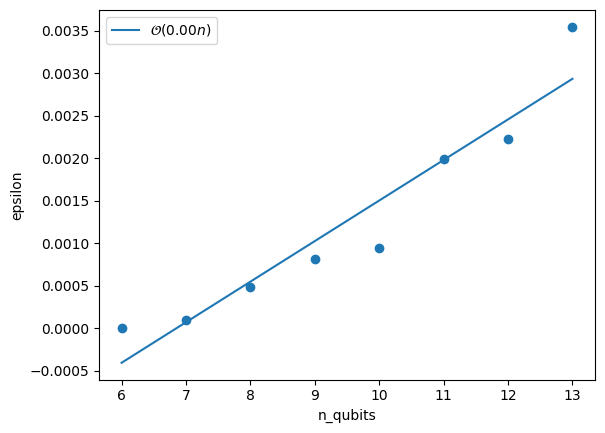

In [12]:
x = epsilon_summary.columns.to_numpy()
y = epsilon_summary.iloc[-1].to_numpy()

# a, b, c = np.polyfit(x, np.log2(y), 2)
# plt.plot(x, 2**(a*x**2+b*x+c), label=r'$\mathcal{{O}}(2^{{{:.2f}n}})$'.format(a))
a, b = np.polyfit(x, y, 1)
plt.plot(x, (a*x+b), label=r'$\mathcal{{O}}({{{:.2f}n}})$'.format(a))

plt.scatter(x, y)
#plt.yscale('log')

plt.xlabel('n_qubits')
plt.ylabel('epsilon')
plt.legend()

<AxesSubplot:>

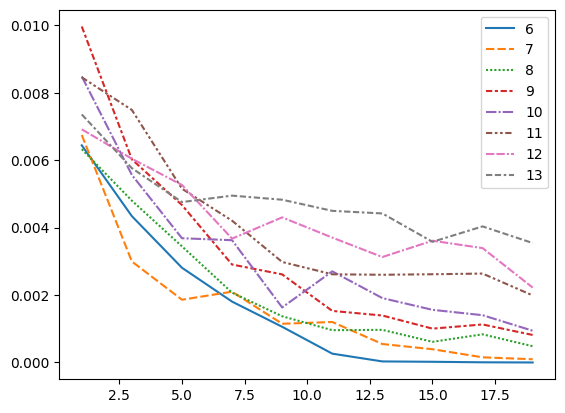

In [13]:
import seaborn as sns
sns.lineplot(epsilon_summary)